<a href="https://colab.research.google.com/github/OnlySem/ITMO/blob/main/%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты библиотек

In [1]:
!pip install --upgrade matplotlib > None

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

%matplotlib inline

# Информация о базе данных

Набор данных состоит из анонимных данных о заработной плате научных сотрудников различных стран по годам.

In [3]:
path = 'https://raw.githubusercontent.com/OnlySem/ITMO/refs/heads/main/DataScience_salaries_2024.csv'
data = pd.read_csv(path)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L


In [4]:
data.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [5]:
data.shape

(14838, 11)

In [6]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,14838.000000,1.483800e+04,14838.000000,14838.000000
mean,2023.138900,1.650227e+05,149874.718763,32.760480
std,0.700799,3.562354e+05,69009.181349,46.488278
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.021000e+05,102000.000000,0.000000
50%,2023.000000,1.422000e+05,141300.000000,0.000000
75%,2024.000000,1.875000e+05,185900.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


In [7]:
data.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


База данных заполнена полностью, пропусков нет

In [8]:
data.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [4]:
cat_cols = data.select_dtypes(include='object')
cat_cols.head()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
0,MI,FT,Data Scientist,CLP,CL,CL,L
1,MI,FT,BI Data Analyst,HUF,HU,US,L
2,MI,FT,Data Scientist,HUF,HU,HU,L
3,MI,FT,ML Engineer,JPY,JP,JP,S
4,SE,FT,Lead Machine Learning Engineer,INR,IN,IN,L


База данных содержит 4 типа квалификации сотрудников, 4 типа трудоустройства сотрудников, 153 должности, 23 типа валюты заработной платы, 88 страны проживания сотрудников, 77 стран расположения компаний и 3 типа размера компании.

In [10]:
cat_cols.describe()

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,14838,14838,14838,14838,14838,14838,14838
unique,4,4,153,23,88,77,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,9696,14772,3162,13682,12926,12975,13674


# Визуализация данных

По тепловой карте видна некоторая зависимость зарплаты сотрудника в USD от: опыта сотрудника, должности, метса жительства сотрудника и страны компании.

<Axes: >

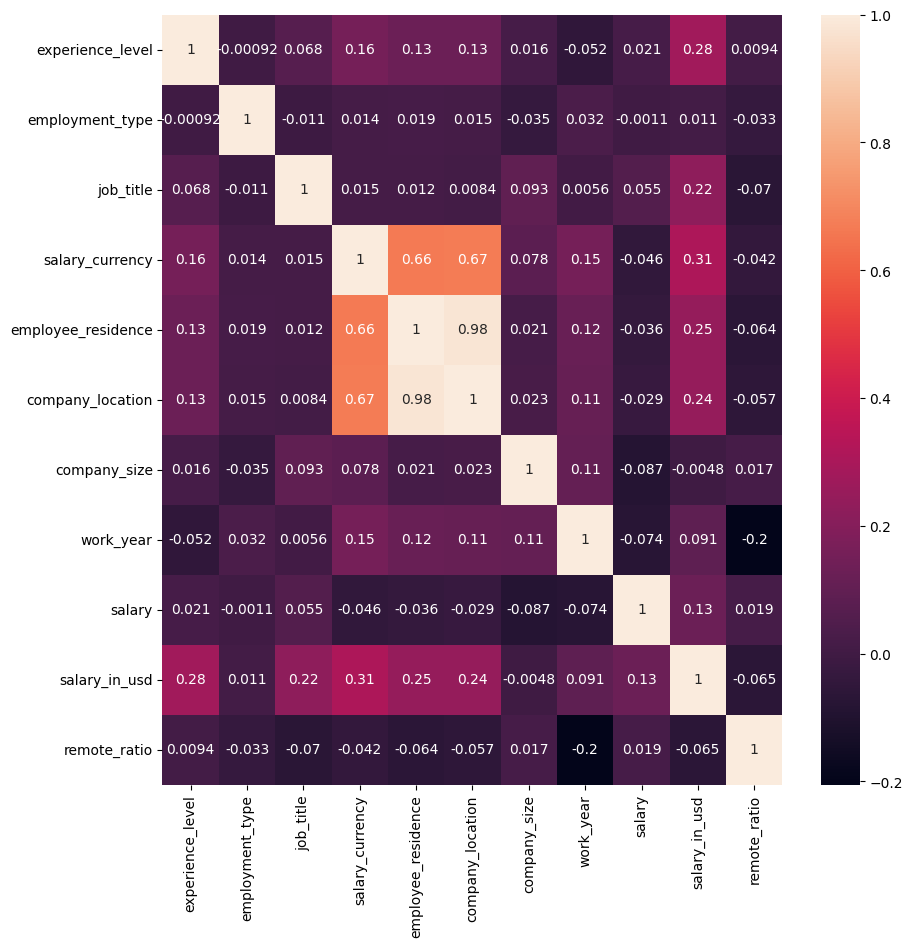

In [5]:
df = cat_cols.copy()
if True:
    le = LabelEncoder()
    for c in cat_cols.columns:
        df[c] = le.fit_transform(cat_cols[c])

num_cols = data.select_dtypes(exclude='object')

df_test = pd.concat([df, num_cols], axis=1, join='outer')

fig, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(df_test.corr(), annot=True)

## Средняя заработной платы в зависимости от опыта сотрудника

In [11]:
data['experience_level'].value_counts()

,count
experience_level,
SE,9696
MI,3553
EN,1148
EX,441


EN - Junior, MI - Mid-level, SE - Senior, EX - Expert

Text(0.5, 1.0, 'experience_level')

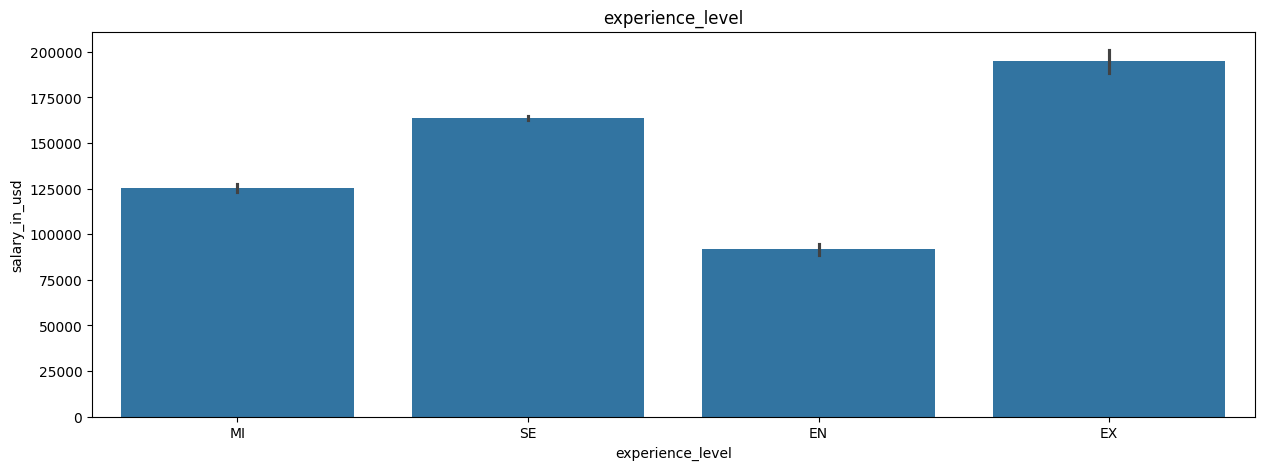

In [75]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'experience_level', y = 'salary_in_usd')
axes.set_title('experience_level')

среднее значение зарплат в зависимости от опыта сотрудника по годам

In [12]:
data.groupby(['experience_level','work_year'])['salary_in_usd'].mean()

experience_level  work_year
EN                2020          69840.666667
                  2021          63463.065217
                  2022          80018.698276
                  2023          91166.310345
                  2024          98308.906188
EX                2020         179958.250000
                  2021         186128.000000
                  2022         188260.292683
                  2023         191314.194215
                  2024         203320.854167
MI                2020          91870.935484
                  2021          86818.390805
                  2022         102733.432961
                  2023         123821.311772
                  2024         136547.600294
SE                2020         138648.894737
                  2021         125989.746667
                  2022         147982.512753
                  2023         165421.026078
                  2024         168214.908784
Name: salary_in_usd, dtype: float64

In [13]:
Junior = data.loc[data['experience_level'] == 'EN']
Expert = data.loc[data['experience_level'] == 'EX']
Mid_level = data.loc[data['experience_level'] == 'MI']
Senior = data.loc[data['experience_level'] == 'SE']

Text(0.5, 1.0, 'Expert')

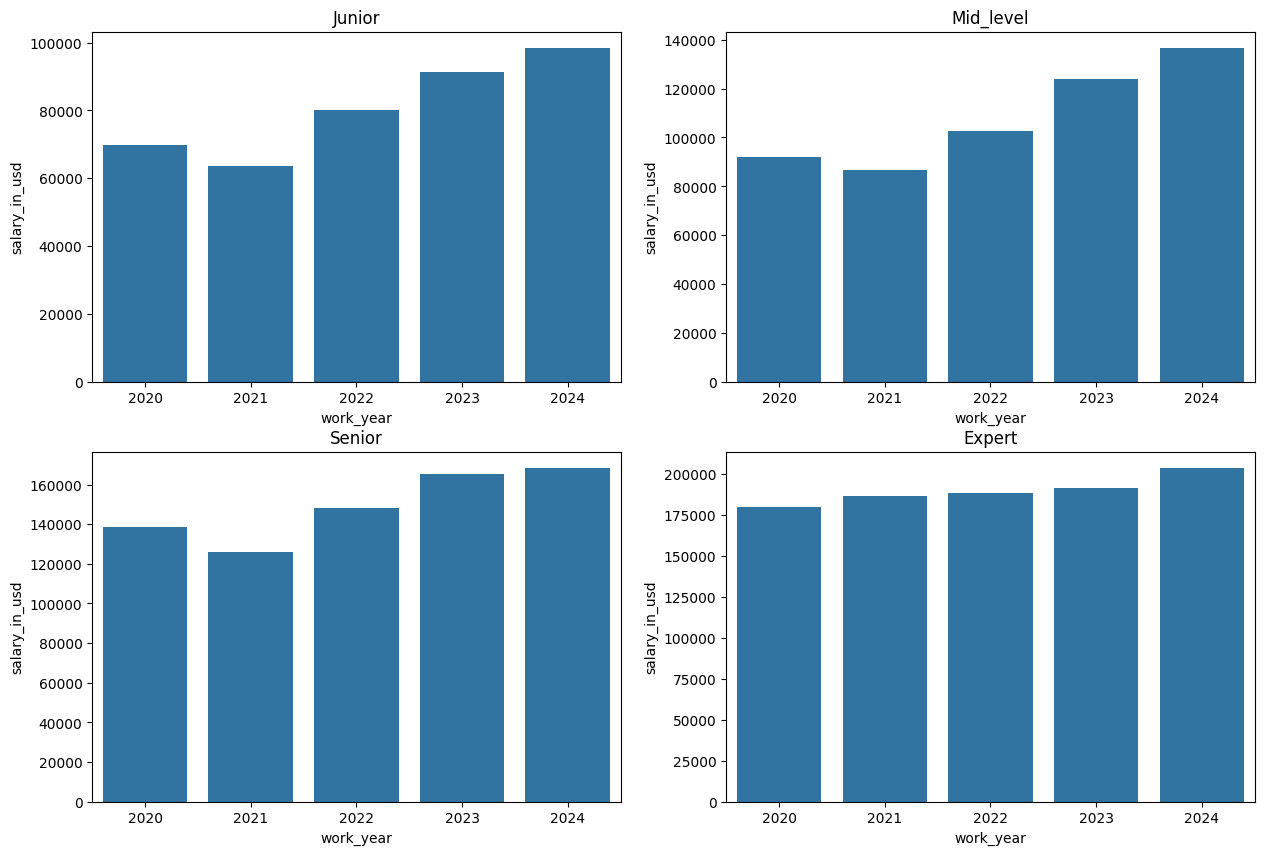

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.barplot(Junior.groupby('work_year')['salary_in_usd'].mean(), ax = axes[0, 0])
axes[0, 0].set_title('Junior')
sns.barplot(Mid_level.groupby('work_year')['salary_in_usd'].mean(), ax = axes[0, 1])
axes[0, 1].set_title('Mid_level')
sns.barplot(Senior.groupby('work_year')['salary_in_usd'].mean(), ax = axes[1, 0])
axes[1, 0].set_title('Senior')
sns.barplot(Expert.groupby('work_year')['salary_in_usd'].mean(), ax = axes[1, 1])
axes[1, 1].set_title('Expert')

Text(0.5, 1.0, 'Expert')

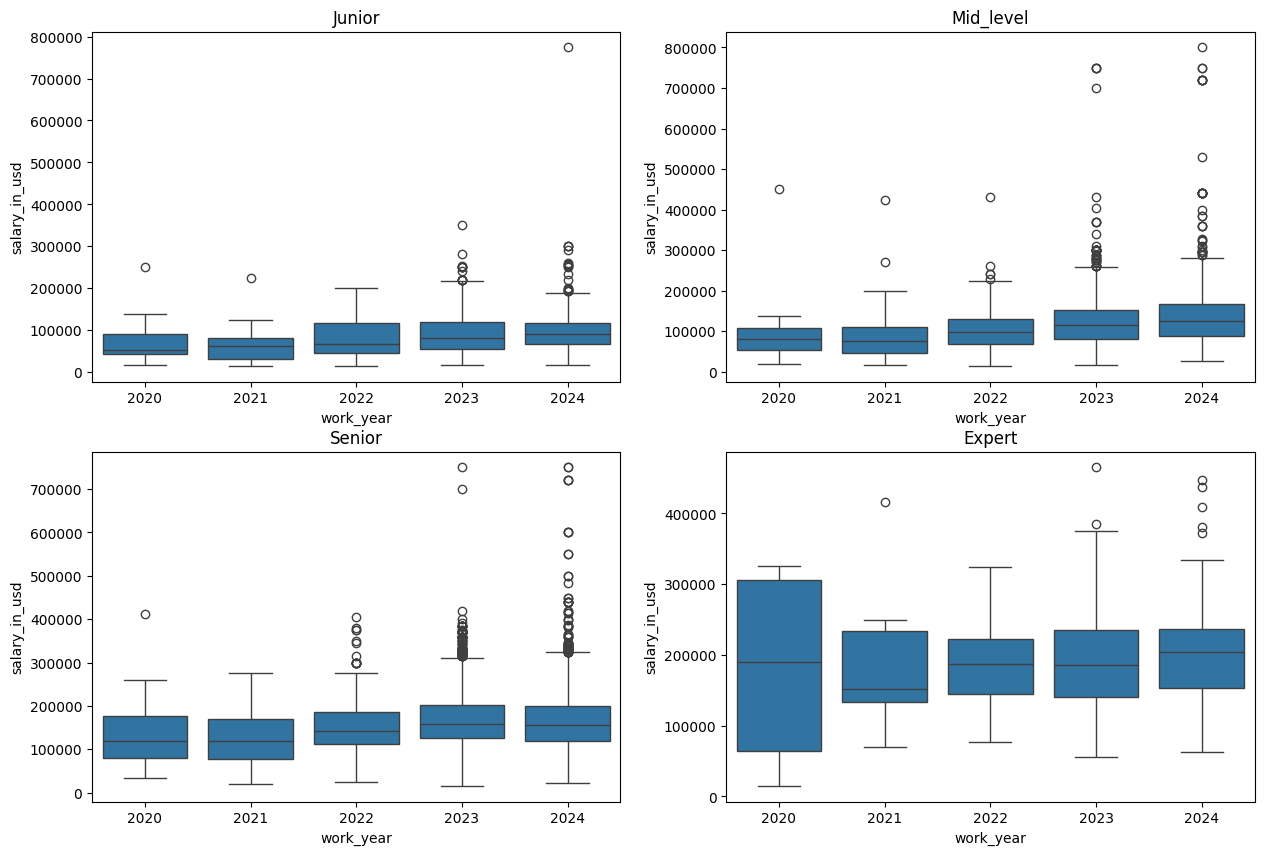

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.boxplot(Junior, x = 'work_year', y = 'salary_in_usd', ax = axes[0, 0])
axes[0, 0].set_title('Junior')
sns.boxplot(Mid_level, x = 'work_year', y = 'salary_in_usd', ax = axes[0, 1])
axes[0, 1].set_title('Mid_level')
sns.boxplot(Senior, x = 'work_year', y = 'salary_in_usd', ax = axes[1, 0])
axes[1, 0].set_title('Senior')
sns.boxplot(Expert, x = 'work_year', y = 'salary_in_usd', ax = axes[1, 1])
axes[1, 1].set_title('Expert')

##Зависимость заработной платы сотрудников от размера компании

Text(0.5, 1.0, 'company_size')

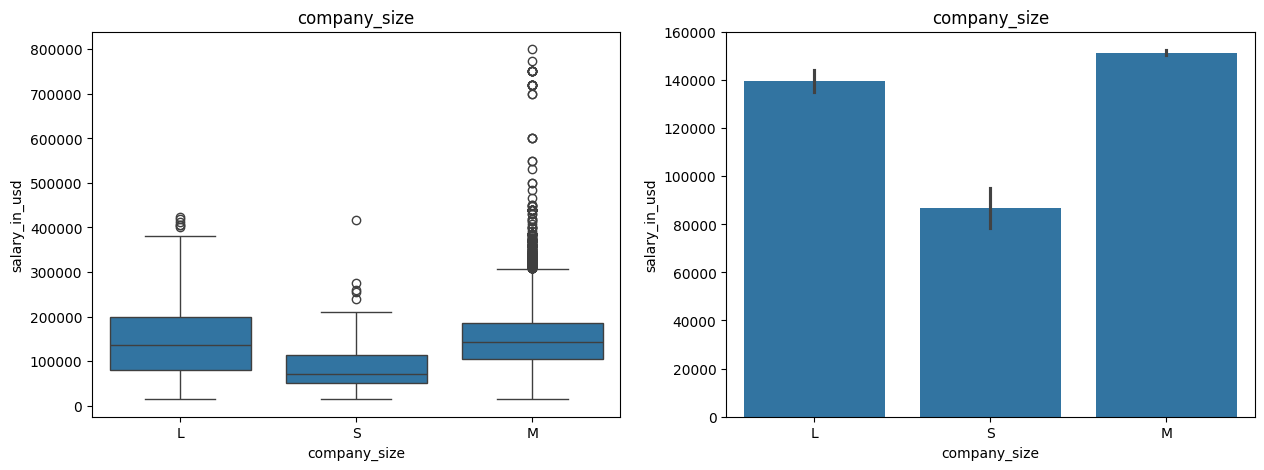

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.boxplot(data, x = 'company_size', y = 'salary_in_usd', ax = axes[0])
axes[0].set_title('company_size')
sns.barplot(data, x = 'company_size', y = 'salary_in_usd', ax = axes[1])
axes[1].set_title('company_size')

##Зависимость заработной платы от страны расположения компании

Text(0.5, 1.0, 'company_location')

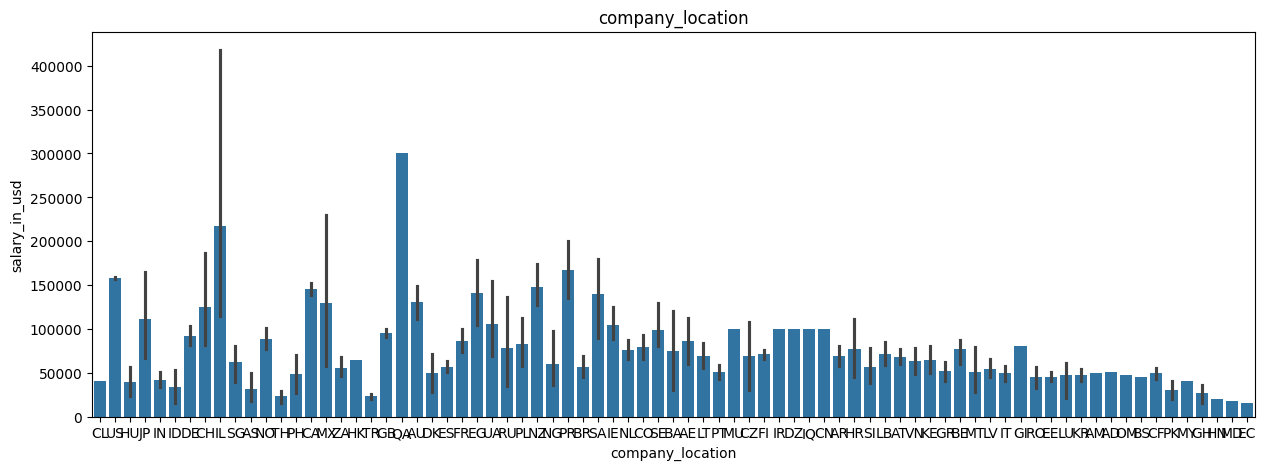

In [70]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'company_location', y = 'salary_in_usd')
axes.set_title('company_location')

##Зависимость заработной платы от места жительства сотрудника

Text(0.5, 1.0, 'employee_residence')

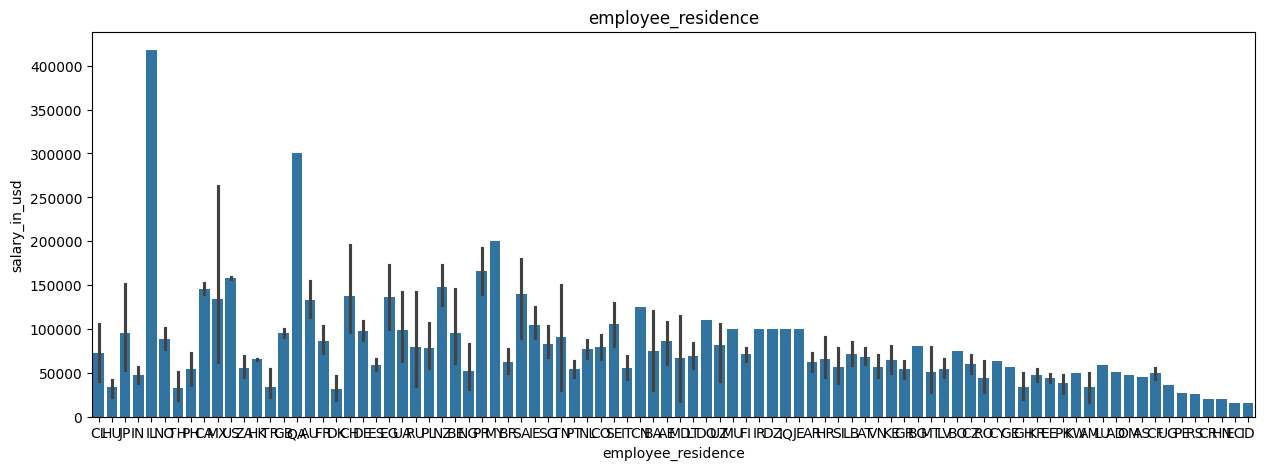

In [73]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'employee_residence', y = 'salary_in_usd')
axes.set_title('employee_residence')

##Зависимость заработной платы от должности сотрудника

Text(0.5, 1.0, 'job_title')

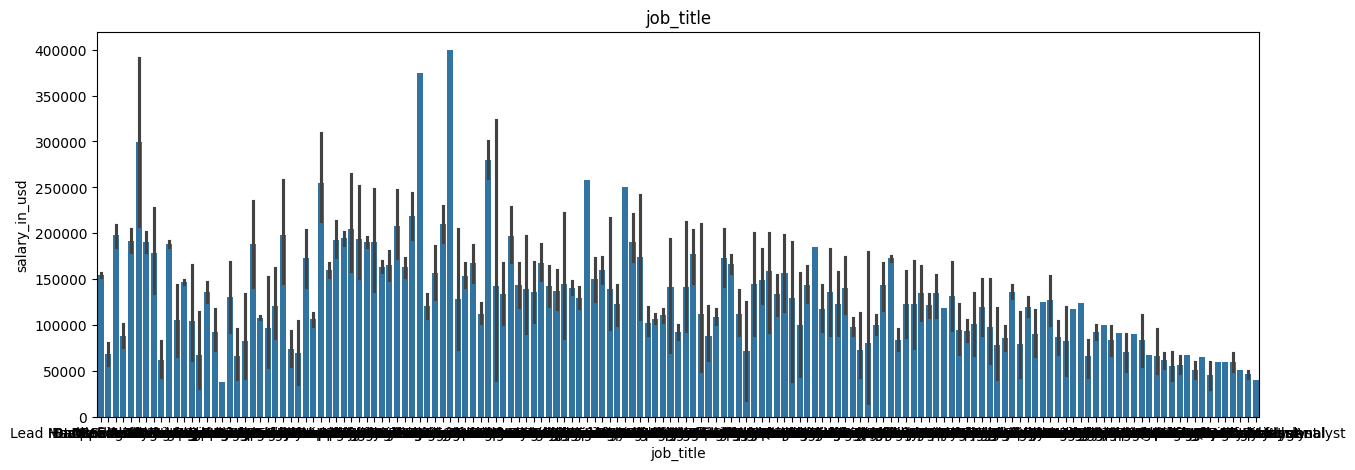

In [66]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.barplot(data, x = 'job_title', y = 'salary_in_usd')
axes.set_title('job_title')

#